In [1]:
# Step 1. Grab a random assortment of frames from cab_ride_trimmed.py

import cv2
import numpy as np
import random
from tqdm import tqdm

def random_frames_from_video(video_path, num_frames=5):
    """
    Extracts random frames from a video and returns them as a list of NumPy arrays.
    
    Parameters:
        video_path (str): Path to the video file.
        num_frames (int): Number of random frames to extract.
        
    Returns:
        list: List of NumPy arrays representing the frames.
    """
    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return []

    frames = []

    for _ in tqdm(range(num_frames)):
        # Get a random frame number
        frame_num = random.randint(0, total_frames - 1)
        # Set the video position to the frame number
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame
        ret, frame = cap.read()

        if ret:
            frames.append(frame)

    # Release the video capture object
    cap.release()
    
    return frames

# Extract random frames from the video
frames = random_frames_from_video('cab_ride_trimmed.mkv', num_frames=2000)

# The 'frames' list now contains 5 randomly extracted frames as NumPy arrays.
# You can process these arrays as needed.


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:57<00:00,  8.42it/s]


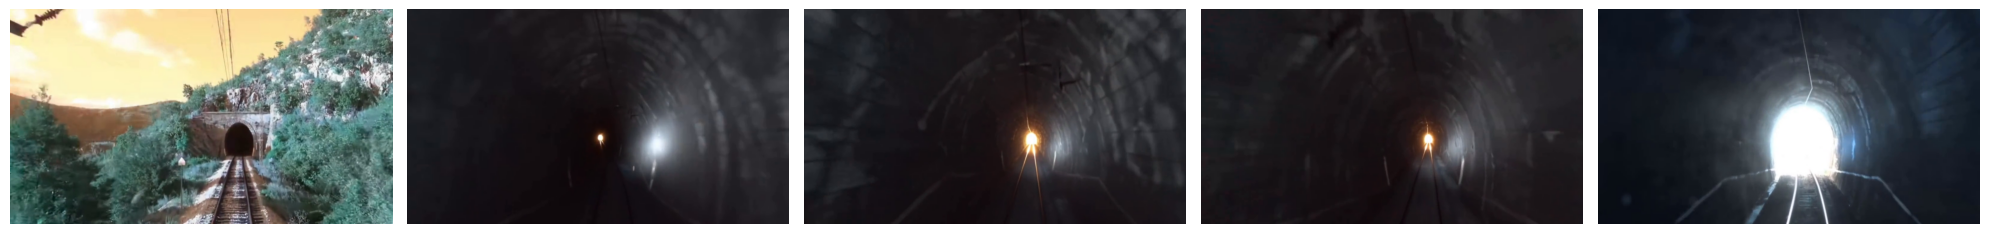

shape: (720, 1280, 3)


In [2]:
# Step 2: preview a random sample of images

import matplotlib.pyplot as plt

# Display up to 5 frames
display_frames = frames[:5]

fig, axs = plt.subplots(1, len(display_frames), figsize=(20, 5))

for ax, frame in zip(axs, display_frames):
    ax.imshow(frame)
    ax.axis('off')

plt.tight_layout()
plt.show()
print("shape:", frames[0].shape)

In [3]:
# Step 3: Get the frames into 1d arrays of pixels
some_frame = frames[0]
print("reshaped frames:", some_frame.reshape(-1, 3))
print("length of the reshaped frames:", len(some_frame.reshape(-1, 3)))

reshaped frames: [[250 248 210]
 [250 248 210]
 [250 249 209]
 ...
 [152 192 195]
 [154 191 195]
 [151 188 192]]
length of the reshaped frames: 921600


In [4]:
reshaped_frames = [frame.reshape(-1, 3) for frame in frames]

In [5]:
# Step 4: Scramble each of the frames in exactly the same way using numpy's fancy indexing
scrambled_indices = np.random.permutation(len(reshaped_frames[0]))
scrambled_frames = []
for frame in tqdm(reshaped_frames):
    scrambled_frames.append(frame[scrambled_indices])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.71it/s]


In [6]:
# Step 5: Create a heuristic to determine the closeness of the pixels

# We'll iterate through each of the frames. For each of the frames, we'll look at the relationship between each pixel value.
# Well... we would do that, but there would be a pretty enourmous combinatorial cost. Instead we'll use random sampling.

# Another issue is that we'll need to create a bucket that stores the correlation data of each pixel to each other.
# a 921600 ^ 2 sized bucket is a very large bucket indeed. So we will need to use a subset of these pixels.

subset_size = 5000
scrambled_frames_subset = [frame[:subset_size] for frame in scrambled_frames]
scrambled_frames_subset = np.array(scrambled_frames_subset)
print(scrambled_frames_subset.shape)

(2000, 5000, 3)


In [7]:
# Then define the actual loss function (is this working??)


def euclidean_distance_2d(image):
    image = np.array(image)
    
    # Reshape the image to have shape (N, 1, 3) and (1, N, 3)
    # where N is the number of pixels.
    a = image[:, np.newaxis, :]
    b = image[np.newaxis, :, :]
    
    # Calculate the squared differences for each RGB channel and sum them.
    squared_diff = np.sum((a - b) ** 2, axis=-1)
    
    # Take the square root to get the Euclidean distance.
    distance = np.sqrt(squared_diff)

    return distance

# Test out the distance function
print(euclidean_distance_2d(scrambled_frames_subset[0]))

# We'll create the accumulation bucket for the loss function...
bucket = np.zeros((subset_size, subset_size))
print(bucket)

[[ 0.         17.23368794 15.68438714 ... 21.61018278 20.27313493
  14.45683229]
 [17.23368794  0.         16.2788206  ... 12.56980509 19.54482029
  21.3541565 ]
 [15.68438714 16.2788206   0.         ... 14.59451952 20.02498439
  12.84523258]
 ...
 [21.61018278 12.56980509 14.59451952 ...  0.         12.32882801
  23.10844002]
 [20.27313493 19.54482029 20.02498439 ... 12.32882801  0.
  19.33907961]
 [14.45683229 21.3541565  12.84523258 ... 23.10844002 19.33907961
   0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
# Step 6: Iterate over each of the frames and add to the bucket
for frame in tqdm(scrambled_frames_subset):
    bucket += euclidean_distance_2d(frame)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [49:27<00:00,  1.48s/it]


In [9]:
bucket

array([[    0.        , 32452.81368268, 32261.47733509, ...,
        32764.41827778, 33219.97701159, 31511.54758661],
       [32452.81368268,     0.        , 30493.35722779, ...,
        29467.99039078, 29719.23153241, 23447.21526362],
       [32261.47733509, 30493.35722779,     0.        , ...,
        28494.37904896, 27845.18245777, 30055.04164489],
       ...,
       [32764.41827778, 29467.99039078, 28494.37904896, ...,
            0.        , 24168.4625833 , 28996.63832671],
       [33219.97701159, 29719.23153241, 27845.18245777, ...,
        24168.4625833 ,     0.        , 29711.59545509],
       [31511.54758661, 23447.21526362, 30055.04164489, ...,
        28996.63832671, 29711.59545509,     0.        ]])

In [15]:
np.min(bucket[0][1:])

13799.09210541207

In [16]:
np.max(bucket[0][1:])

34984.44203419381

In [17]:
np.mean(bucket[0][1:])

31615.856728804865